In [2]:
from get_all_metrics import get_metrics
import compile_benchmark_metrics

# RANGE = range(2500, 5000, 500)
# PERCENTILE = '99'
# FILENAME = '../results/phase3_final_400000ops_'
# TH_RANGE = list(range(4, 26, 3))

RANGE = list(range(1500, 5000, 500))
PERCENTILE = '99.9'
FILENAME = '../results/phase3_final_1000000ops_'
TH_RANGE = list(range(4, 35, 3))

# RANGE = list(range(1500, 5000, 500))
# PERCENTILE = '80'
# FILENAME = '../results/phase3_final_1000000ops_'
# TH_RANGE = list(range(4, 35, 3))

print(len(RANGE))
print(len(TH_RANGE))

# Get performance data for all load for a sigle threshold
def get_performance_for_threshold(threshold):
    data_list = []
    for load in RANGE:
        node_data = list(get_metrics(FILENAME+str(threshold)+"_" + str(load)))
        data = compile_benchmark_metrics.get_statistics(node_data)
        data_list.append((data, load))
    return data_list

def get_throughput_and_percentile(percentile, filename):
    file = open(filename, "r")
    lines = list(map(lambda line: line.rstrip('\n'), file.readlines()))
    
    latency_line = [line for line in lines if line.find("[READ], " + percentile) != -1][0]
    throughput_line = [line for line in lines if line.find("Throughput(ops/sec)") != -1][0]
    
    latency = latency_line.split()[-1]
    throughput = throughput_line.split()[-1]
    return latency, throughput

# Return tuple with the real throughput from ycsb and the latency from ycsb
def get_latency_tuple(load, threshold, filename_prefix = FILENAME):
    filename = filename_prefix + str(threshold) + "_" + str(load)
    latency, throughput = get_throughput_and_percentile(PERCENTILE, filename)
    return (float(throughput), int(latency))

# Get all the tuples
def get_latencies_for_threshold(threshold = 1, filename_prefix = FILENAME):
    return list(map(lambda load: get_latency_tuple(load, threshold, filename_prefix), RANGE))

print (get_performance_for_threshold(1)[0])
print (get_latencies_for_threshold(1)[0])

7
11
((371.5, 28.25, 19.5, 0.25), 1500)
(1487.5661781003482, 32495)


In [11]:
# Get files for a threshold. 
# Both file with performance and latency and add them
def get_all_for_threshold(threshold):
    performance_data = get_performance_for_threshold(threshold)
    latency_data = get_latencies_for_threshold(threshold)
    
    
    return [(p, latency) for (p, (_th, latency)) in zip(performance_data, latency_data)]
    
# Do this for every threshold and make one list of them
def get_all_data():
    all_data = []
    for th in TH_RANGE:
        d = get_all_for_threshold(th)
        l = zip(d, [th] * len(d))
        all_data.extend(l)
    return all_data

# [(x, y, weight) for ((x, weight), y) in get_all_data()][0]
[(((x[0], x[2]), x_target), y, weight) for (((x, x_target), weight), y) in get_all_data()][0]

# (((492.375, 72.921875, 25.25, 0.6875), 2000), 4, 44319)
# (((read_throughput, read_variance, write_throughput, write_variance), target_load), speculative_threshold, latency_by_ycsb)

(((367.125, 19.25), 1500), 4, 34015)

In [13]:
from sklearn.preprocessing import MinMaxScaler
import itertools
import numpy as np

# Extract data and scale it to something reasonable
def get_scaled_data():
    # Getting and extracing the data vector
#     data = [(x, y, weight) for ((x, weight), y) in get_all_data()]
    data = [(((x[0], x[2]), x_target), y, weight) for (((x, x_target), weight), y) in get_all_data()]
    x, y, weight = zip(*itertools.chain(data))

    def weight_transformer(v):
        return (1 - v)**5

    # Scaling weights. MinMax gives 0 for the lowest and 1 for the highest. Linear
    # I apply the weight_transformer() to give higher weights to those elements that really matter.
    scaler = MinMaxScaler()
    scaler.fit(np.asarray(weight).reshape(-1, 1))
    s_weight = scaler.transform(np.asarray(weight).reshape(-1, 1))
    s_weight = [weight_transformer(e[0]) for e in s_weight]

    # Extracting the load vs target load
    x_target = [target for (_x, target) in x]
    x_load = [x for (x, _target) in x]
    
    return (x_load, x_target, y, s_weight)

x, x_target, y, w = get_scaled_data()
print(x[0])
print(x_target[0])
print(y[0])
print(w[0])

(367.125, 19.25)
1500
4
0.30466456906535483


10.126696047518962
[-0.11445425  2.36446206]


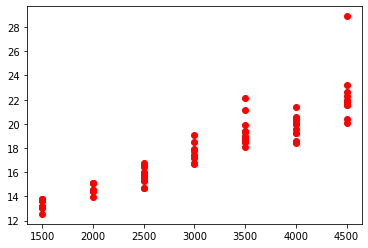

In [16]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Getting the data and fitting it to the linear regression
x, x_target, y, w = get_scaled_data()
model = LinearRegression()
# We make the model between cassandra performance x and sr threshold
# The way it works is by weighting the points by how good they are in terms of latency
# There are points everywhere with this, but only those with low latency really
# count towards the regression. Look at the bottom for a quick look at the data.
reg = model.fit(np.asarray(x), np.asarray(y), sample_weight=np.asarray(w))

print(reg.intercept_)
print(reg.coef_)

# Creating predictions based on the same values as we trained model
# Plot the prediction for those values against the probable load of the system
# (target load of ycsb)
predictions = list(reg.predict(np.array(x)))
plt.scatter(x_target, predictions, color='r')

# with open('linear_regression.csv', 'w') as f:
#     f.write("taget, prediction\n")
    
#     for target, prediction in zip(x_target, predictions):
#         f.write(str(target) + ", " + str(prediction) + "\n")

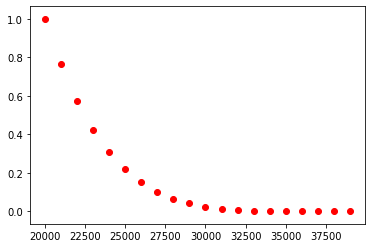

In [15]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Example curve of the scaling

def plot_scaling_curve():
    y_range = list(range(20000, 40000, 1000))
    
    def weight_transformer(v):
            return (1 - v)**5

    # Scaling weights. MinMax gives 0 for the lowest and 1 for the highest. Linear
    # I apply the weight_transformer() to give higher weights to those elements that really matter.
    scaler = MinMaxScaler()
    scaler.fit(np.asarray(y_range).reshape(-1, 1))
    s_weight = scaler.transform(np.asarray(y_range).reshape(-1, 1))
    s_weight = [weight_transformer(e[0]) for e in s_weight]
    
    with open("scaling-points.csv", "w") as f:
        f.write("x, y\n")
        for x, y in zip(y_range, s_weight):
            f.write(str(x) + ", " + str(y) + "\n")
    
    plt.scatter(y_range, s_weight, color='r')
    
# We can see that values which has low latency are important (we want to predict that this is good)
# while the large values are not very important.
plot_scaling_curve()

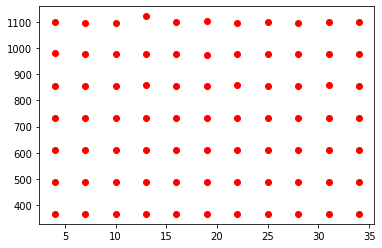

In [70]:
# This is basically what the data looks like before the regression (just dropping 3 out of four regressions)
# this is expected as it only shows all the benchmark we ran. Instead we make the regression by
# basing it on the importance of certain dots (how low latency they have.)

def distribution_between_x_and_y():
    x, x_target, y, w = get_scaled_data()
    X = [e[0] for e in x]
    plt.scatter(y, X, color='r')
    
distribution_between_x_and_y()

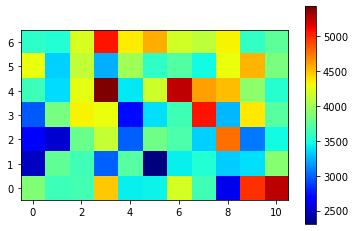

In [19]:
# This can be visualized with a heatmap
import itertools
import numpy as np
import matplotlib.pyplot as p


def get_heatmap_data():
    def get_list_for_threshold (threshold): 
        latencies = get_latencies_for_threshold(threshold)

        thresholds = [threshold] * len(latencies)

        values = [
            (x, y, z) for ((x, z), y) in zip(latencies, thresholds)
        ]

        return values

    big_list = []
    for i in TH_RANGE:
        big_list.append(get_list_for_threshold(i))

    X, Y, Z = zip(*itertools.chain(*big_list))


    X = np.array(list(X))
    Y = np.array(list(Y))
    Z = np.array(list(Z))

    color_map = []

    for i in range(len(big_list[0])):
        z = []
        for elem in big_list:
            _e1, _e2, e3 = elem[i]
            z.append(e3)
        color_map.append(z)
    
    return color_map

%matplotlib inline
p.imshow(get_heatmap_data(),interpolation='none',cmap=p.cm.jet,origin='lower')  
# many other colormaps can be seen here: http://matplotlib.org/examples/color/colormaps_reference.html
p.colorbar()

with open('heatmap.csv', 'w') as f:
    f.write("load, ")
    
    iteration = 1;
    for threshold in TH_RANGE:
        f.write(str(threshold))
        if iteration < len(TH_RANGE):
            f.write(", ")
            
        iteration += 1
        
    f.write("\n")
    
    load_it = 0
    for load_line in get_heatmap_data():
        iteration = 1;
        f.write(str(RANGE[load_it]) + ", ")
        for sr_threshold in load_line:
            f.write(str(sr_threshold))
            if iteration < len(TH_RANGE):
                f.write(", ")
                
            iteration += 1
            
        f.write("\n")
        load_it += 1


# The x axis is all the thresholds we are running, y is all the loads we are trying and
# the color represents the latency.
# this is relatively similar to the graph above but with colors/latencies